Current Model MSE Scores:
1. ARIMA (3, 1, 0): 372049
2. ARIMAX (3, 1, 0): 322138
3. ARIMAX (3, 1, 0) with 7d and 14d lags: 133317
4. ARIMAX (3, 1, 0) with 7d lags: 133429
5. ARIMAX (3, 1, 0) with 14d lags: 143954
6. ARIMAX (3, 1, 0) with 80-20 train test split: 142600
7. ARIMAX (3, 1, 0) with just google trends: 147727

### Import Libraries

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#import warnings
#warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Import Data

In [2]:
# Import the dataset
data = pd.read_csv("../datasets/merged_df2.csv")

In [3]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


No catagorical values observed. However, due to the different types of numerical values being used, scaling will be required.

In [4]:
# Check the shape of the data
data.shape

(257, 13)

In [5]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       257 non-null    object 
 1   dengue_cases               257 non-null    int64  
 2   denv_1                     257 non-null    float64
 3   denv_2                     257 non-null    float64
 4   denv_3                     257 non-null    float64
 5   denv_4                     257 non-null    float64
 6   Mean Temperature (°C)      257 non-null    float64
 7   Mean Wind Speed (km/h)     257 non-null    float64
 8   Daily Rainfall Total (mm)  257 non-null    float64
 9   Maximum Temperature (°C)   257 non-null    float64
 10  Max Wind Speed (km/h)      257 non-null    float64
 11  Minimum Temperature (°C)   257 non-null    float64
 12  google_trends              257 non-null    int64  
dtypes: float64(10), int64(2), object(1)
memory usage: 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [6]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [7]:
# Set the time as the index
data = data.set_index('time')

In [8]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
time,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


### Train/Test Split

In [9]:
# Train data will coveer 2018 to 2021
train = data.iloc[:195]

In [10]:
# Test data will cover 2022 to March 2023
test = data.iloc[195:]

In [11]:
train.shape

(195, 12)

In [12]:
test.shape

(62, 12)

In [13]:
62/195

0.31794871794871793

Overall, this is about a 30% train test split:
* Train: 70% of data
* Test: 30% of data

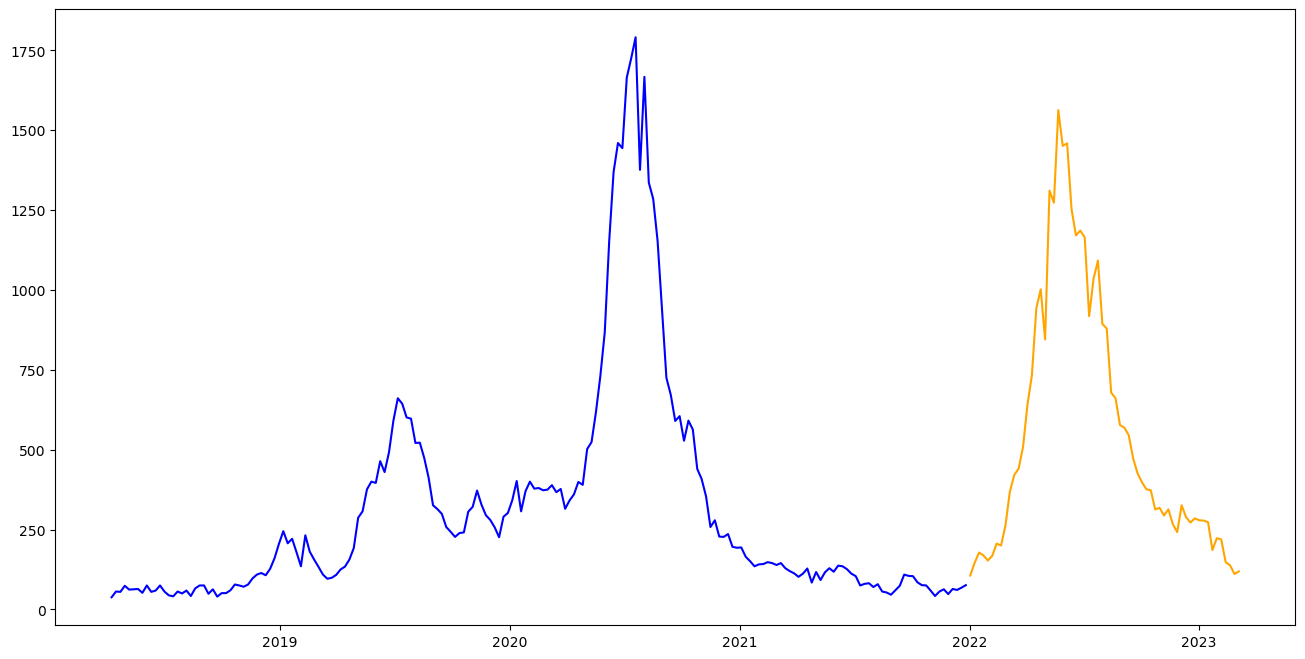

In [14]:
# Time series plot of the train and test data
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train['dengue_cases'], c='blue')
    plt.plot(test['dengue_cases'], c='orange');
    
train_test_plot(train, test)

### Stationarity Test

We will use the stationarity test to identify the $d$ parameter for the ARIMA model

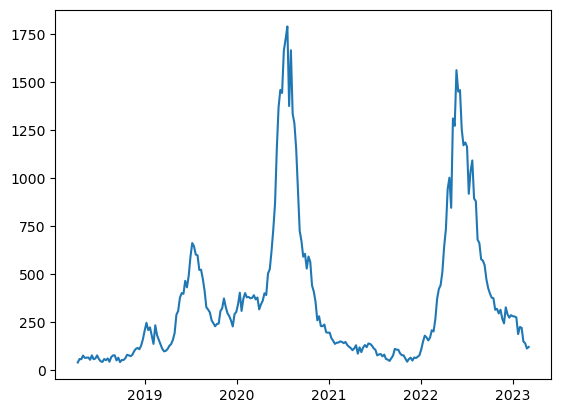

In [15]:
# Plot the data
plt.plot(data['dengue_cases']);

The time series of the dengue cases is clearly not stationary

In [16]:
# Instantiate a new dataframe for the difference information
diff = pd.DataFrame()

In [17]:
# Calculate the first difference of the dengue cases
diff['first_diff_dengue'] = data['dengue_cases'].diff()

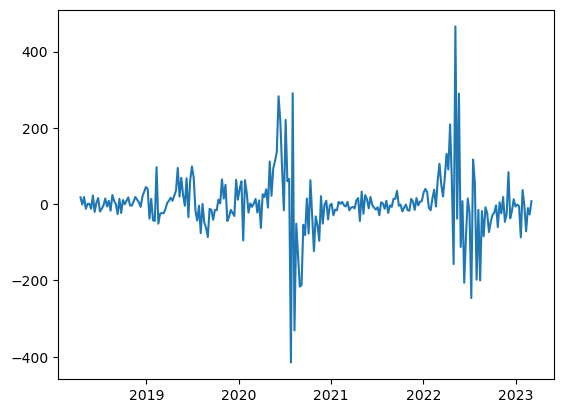

In [18]:
# Plot the first difference of the dengue cases
plt.plot(diff['first_diff_dengue']);

From the plot above, we can see that when the data is differenced once, the data is stationary. 

#### Augmented Dickey-Fuller Test

Let's also use the ADF test to test for Stationarity

In [19]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [20]:
# Run the ADF test on the original dengue data
interpret_dftest(adfuller(data['dengue_cases']))

Test Statistic   -2.549748
p-value           0.103834
dtype: float64

The p-value is above 0.05, hence this data is not stationary.

In [21]:
# Run the ADF test on the differenced dengue data
interpret_dftest(adfuller(data['dengue_cases'].diff().dropna()))

Test Statistic   -5.242290
p-value           0.000007
dtype: float64

The p-value is below 0.05 and we can conclude that the once differenced data is stationary. This is also in line with the differenced data plot. Hence, we can set the $d$ value to $1$.

### Finding the $p$ and $q$ values

We can use a ACF and PACF plot to find the $p$ and $q$ values.

#### ACF and PACF Plot for $p$ value

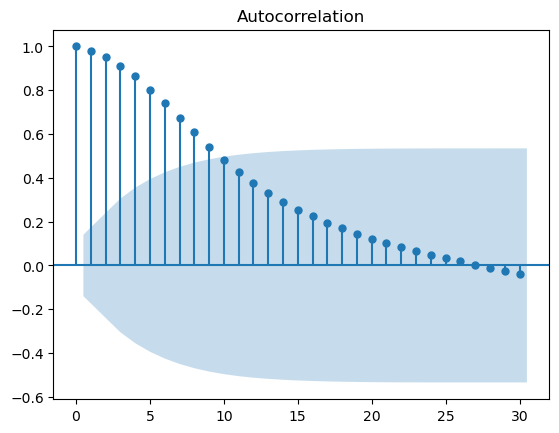

In [22]:
# Generate autocorrelation plot on training data.
plot_acf(train['dengue_cases'], lags = 30);

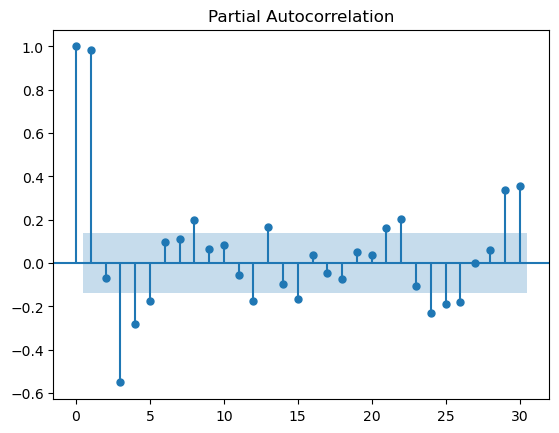

In [23]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['dengue_cases'], lags = 30);

The first lag of the ACF plot is also positive. There is also a sharp cut off in the PACF plot after the second lag. Hence, we can take the next lag of the PACF as the $p$ value and set it to $3$. 

As the $AR$ and $MA$ terms might work against each other and we were able to identify the $p$ value, we will set the $q$ value as $0$.  

### ARIMA Model (3, 1, 0)

Next, we can fit the ARIMA model and run the prediction.

In [24]:
# Instantiate best model.
arima = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set
preds = model.predict(start=195, end=256)

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [25]:
print(f"test head: {test['dengue_cases'].head(1)}")
print(f"pred head: {preds.head(1)}")
print()
print(f"test tail: {test['dengue_cases'].tail(1)}")
print(f"pred tail: {preds.tail(1)}")

test head: time
2022-01-02    106
Name: dengue_cases, dtype: int64
pred head: 2022-01-02    78.117742
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    95.530368
Freq: W-SUN, Name: predicted_mean, dtype: float64


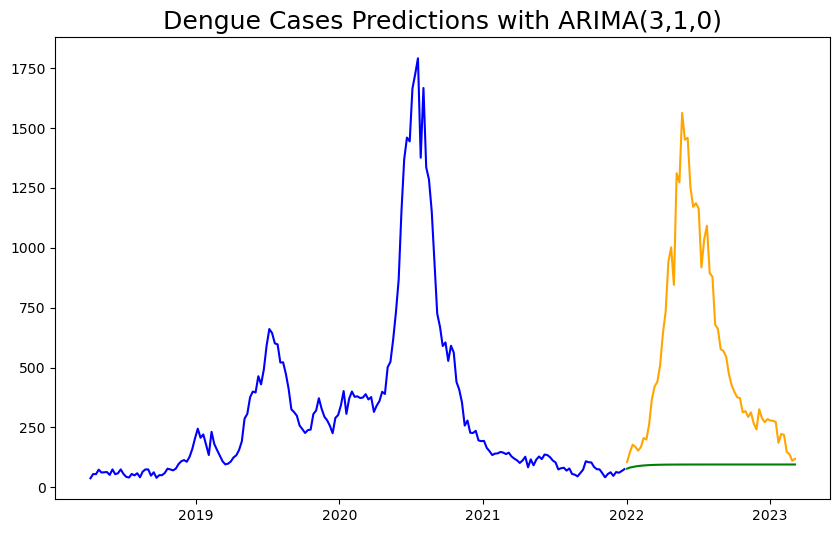

In [26]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMA(3,1,0)', fontsize=18)
plt.show();

In [27]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

372049.91695352225

In [28]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

609.9589469411218

In [29]:
# Evaluation of the model
error = round(mean_squared_error(test['dengue_cases'], preds, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 9791.0.
MSE relative to maximum values in dengue cases: 208.0.


Looking at the MSE values as well as the ratio of the mean squared error to the minimum and maximum values in the dengue cases, we can see that the model is not very good. 

#### Residual Plot

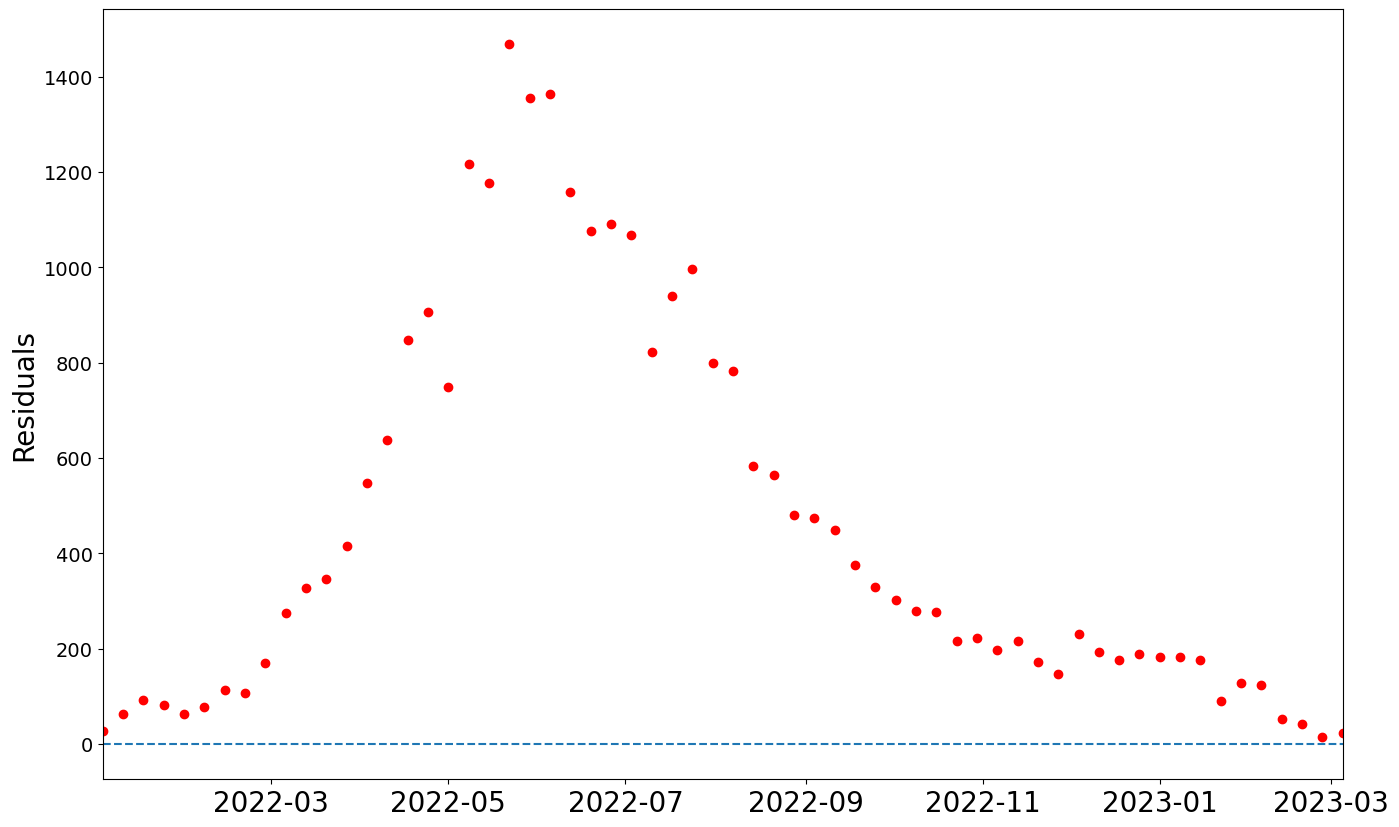

In [30]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

From the residual plot, we can see that the prediction is off to a high degree.

### ARIMAX Model

As we also have other features such as serology data, climate data and google trends, we can use an ARIMAX model to incorporate these features into the model. 

In [32]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
preds2 = model_2.predict(start=195, end=256, exog=test.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [33]:
print(f"test head: {test['dengue_cases'].head(1)}")
print(f"pred head: {preds.head(1)}")
print()
print(f"test tail: {test['dengue_cases'].tail(1)}")
print(f"pred tail: {preds.tail(1)}")

test head: time
2022-01-02    106
Name: dengue_cases, dtype: int64
pred head: 2022-01-02    78.117742
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    95.530368
Freq: W-SUN, Name: predicted_mean, dtype: float64


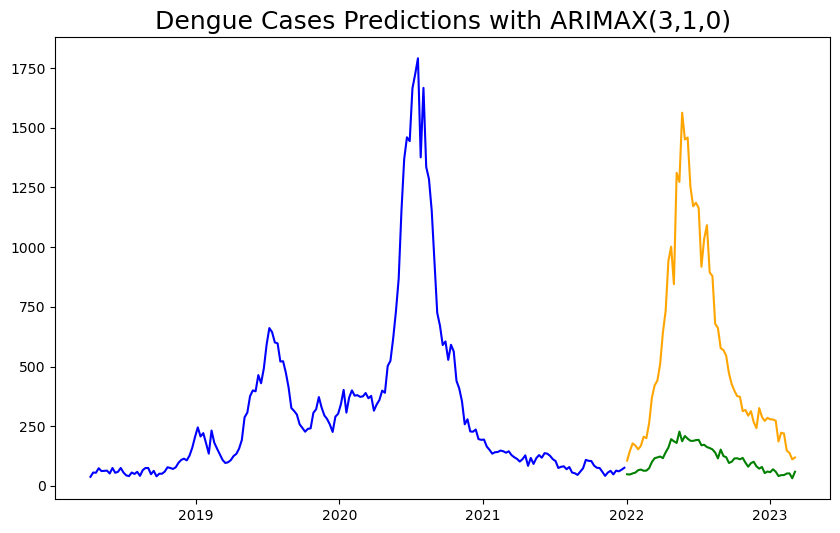

In [34]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds2, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

In [35]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds2)

319908.62936588755

In [36]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds2, squared=False)

565.6046581897001

In [36]:
# Evaluation of the model
error = round(mean_squared_error(test['dengue_cases'], preds2, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 8477.0.
MSE relative to maximum values in dengue cases: 180.0.


#### Residual Plot

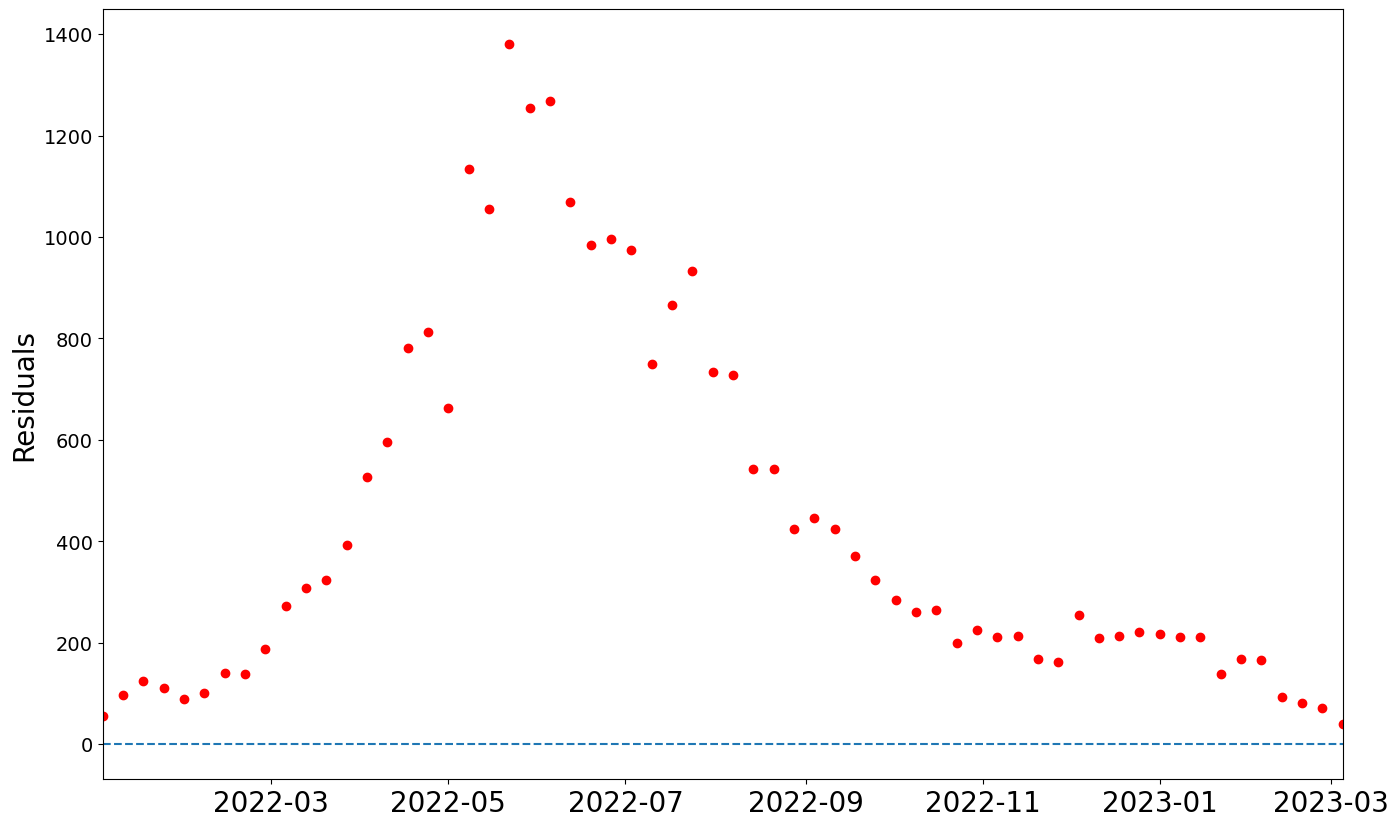

In [37]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds2.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### Feature Engineering

We'll restart the whole data processsing here to engineer new features.

In [38]:
# Import the dataset
data2 = pd.read_csv("../datasets/merged_df2.csv")

In [39]:
data2.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


Feature engineering<br>
1. No need to engineer the serology numbers as they are just the percentage of the current cases
2. No need to engineer the google-trends data as people search as they get infected
3. Try 7 and 14 days lag for the climate data

In [40]:
lag_features = ['Mean Temperature (°C)', 'Mean Wind Speed (km/h)', 
               'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)', 
               'Max Wind Speed (km/h)', 'Minimum Temperature (°C)']

window1 = 7
window2 = 14

In [41]:
for feature in lag_features:
    data2[f"{feature}_lag{window1}"] = data2[feature].shift(window1)
    data2[f"{feature}_lag{window2}"] = data2[feature].shift(window2)

In [42]:
data2.dropna(inplace=True)

In [43]:
data2['time'] = pd.to_datetime(data2['time'])
data2 = data2.set_index('time')

In [44]:
data2.shape

(243, 24)

In [45]:
0.8 * 243

194.4

In [46]:
train2 = data2.iloc[:194]
test2 = data2.iloc[194:]

In [47]:
train2.shape

(194, 24)

In [48]:
test2.shape

(49, 24)

In [49]:
train2.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag7,Mean Temperature (°C)_lag14,Mean Wind Speed (km/h)_lag7,Mean Wind Speed (km/h)_lag14,Daily Rainfall Total (mm)_lag7,Daily Rainfall Total (mm)_lag14,Maximum Temperature (°C)_lag7,Maximum Temperature (°C)_lag14,Max Wind Speed (km/h)_lag7,Max Wind Speed (km/h)_lag14,Minimum Temperature (°C)_lag7,Minimum Temperature (°C)_lag14
time,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-15,41,0.307,0.467,0.173,0.053,28.257143,10.285714,8.371429,32.3,51.1,21.9,22,28.314286,28.528571,6.914286,10.714286,6.914286,0.742857,33.1,33.8,49.3,36.7,24.0,25.5
2018-07-22,56,0.307,0.467,0.173,0.053,28.914286,11.514286,1.285714,31.9,40.0,23.5,23,27.842857,28.914286,5.600000,9.828571,17.371429,2.057143,32.9,34.4,45.0,38.2,22.9,24.6
2018-07-29,50,0.307,0.467,0.173,0.053,29.000000,12.400000,0.742857,33.0,41.0,24.9,25,29.728571,28.142857,9.557143,7.700000,0.600000,0.371429,33.4,34.3,36.4,37.1,24.2,25.5
2018-08-05,59,0.355,0.477,0.103,0.065,27.814286,10.028571,5.485714,32.4,40.3,24.0,21,29.100000,28.414286,9.328571,6.842857,1.685714,4.800000,33.1,35.0,42.5,43.6,23.6,22.6
2018-08-12,42,0.355,0.477,0.103,0.065,28.571429,10.342857,0.971429,33.0,40.0,21.9,17,27.742857,28.785714,8.271429,8.328571,4.628571,3.742857,32.2,34.2,47.2,44.6,23.6,23.6


In [50]:
exogenous_features = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag7', 'Mean Temperature (°C)_lag14',
       'Mean Wind Speed (km/h)_lag7', 'Mean Wind Speed (km/h)_lag14',
       'Daily Rainfall Total (mm)_lag7', 'Daily Rainfall Total (mm)_lag14',
       'Maximum Temperature (°C)_lag7', 'Maximum Temperature (°C)_lag14',
       'Max Wind Speed (km/h)_lag7', 'Max Wind Speed (km/h)_lag14',
       'Minimum Temperature (°C)_lag7', 'Minimum Temperature (°C)_lag14', 'google_trends']

exogenous_features_7d = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag7', 
       'Mean Wind Speed (km/h)_lag7', 
       'Daily Rainfall Total (mm)_lag7', 
       'Maximum Temperature (°C)_lag7', 
       'Max Wind Speed (km/h)_lag7', 
       'Minimum Temperature (°C)_lag7', 'google_trends']

exogenous_features_14d = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag14', 
       'Mean Wind Speed (km/h)_lag14', 
       'Daily Rainfall Total (mm)_lag14', 
       'Maximum Temperature (°C)_lag14', 
       'Max Wind Speed (km/h)_lag14', 
       'Minimum Temperature (°C)_lag14', 'google_trends']

### ARIMAX Model with 7d and 14d lags

In [51]:
# Instantiate best model.
arimax3 = ARIMA(endog=train2['dengue_cases'], order=(3, 1, 0), 
               exog=train2[exogenous_features])

# Fit ARIMA model.
model_3 = arimax3.fit()

# Generate predictions based on test set.
preds3 = model_3.predict(start=194, end=242, exog=test2[exogenous_features])

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [52]:
print(f"test head: {test2['dengue_cases'].head(1)}")
print(f"pred head: {preds3.head(1)}")
print()
print(f"test tail: {test2['dengue_cases'].tail(1)}")
print(f"pred tail: {preds3.tail(1)}")

test head: time
2022-04-03    642
Name: dengue_cases, dtype: int64
pred head: 2022-04-03    479.233641
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    534.452531
Freq: W-SUN, Name: predicted_mean, dtype: float64


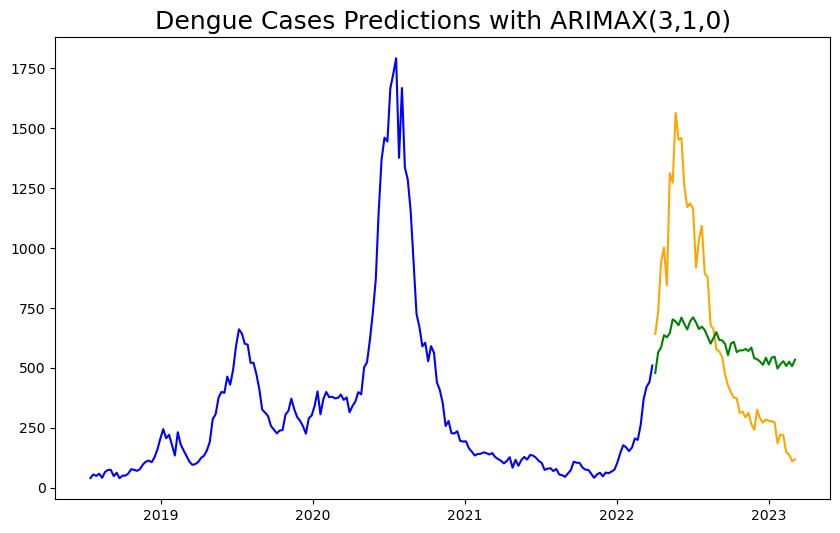

In [53]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train2['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test2['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds3, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

In [54]:
# Evaluate the predictions MSE
mean_squared_error(test2['dengue_cases'], preds3)

133317.02712309468

In [55]:
# Evaluate the predictions with mean error
mean_squared_error(test2['dengue_cases'], preds3, squared=False)

365.1260427894656

In [56]:
# Evaluation of the model
error = round(mean_squared_error(test2['dengue_cases'], preds3, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 3508.0.
MSE relative to maximum values in dengue cases: 74.0.


#### Residual Plot

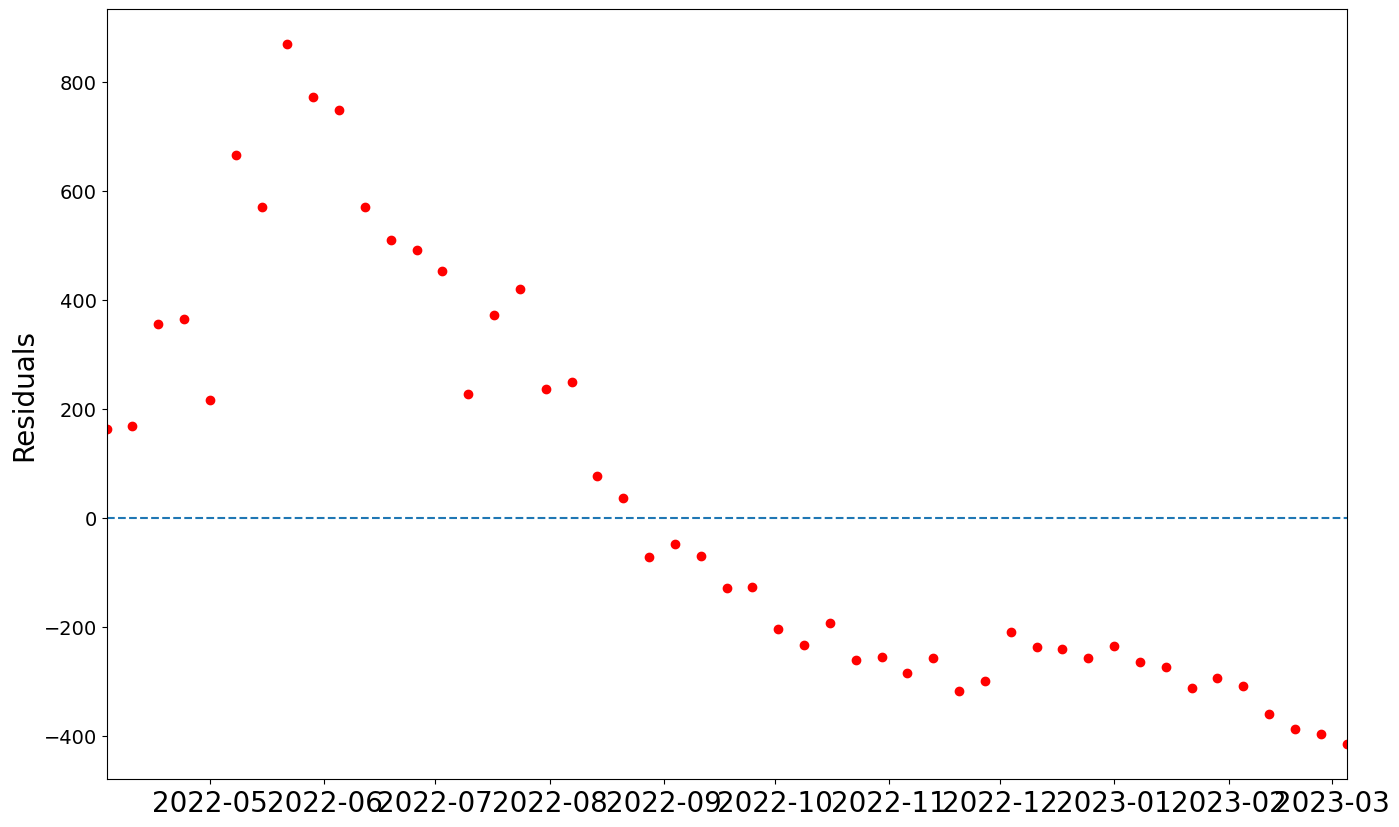

In [57]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test2['dengue_cases'].values - preds3.values

# Generate scatterplot of residuals.
plt.scatter(test2['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test2['dengue_cases'].index.min(),
           xmax = test2['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test2['dengue_cases'].index.min(), test2['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### ARIMAX Model with 7d lags

In [58]:
# Instantiate best model.
arimax4 = ARIMA(endog=train2['dengue_cases'], order=(3, 1, 0), 
               exog=train2[exogenous_features_7d])

# Fit ARIMA model.
model_4 = arimax4.fit()

# Generate predictions based on test set.
preds4 = model_4.predict(start=194, end=242, exog=test2[exogenous_features_7d])

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [59]:
print(f"test head: {test2['dengue_cases'].head(1)}")
print(f"pred head: {preds4.head(1)}")
print()
print(f"test tail: {test2['dengue_cases'].tail(1)}")
print(f"pred tail: {preds4.tail(1)}")

test head: time
2022-04-03    642
Name: dengue_cases, dtype: int64
pred head: 2022-04-03    486.10344
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    538.294188
Freq: W-SUN, Name: predicted_mean, dtype: float64


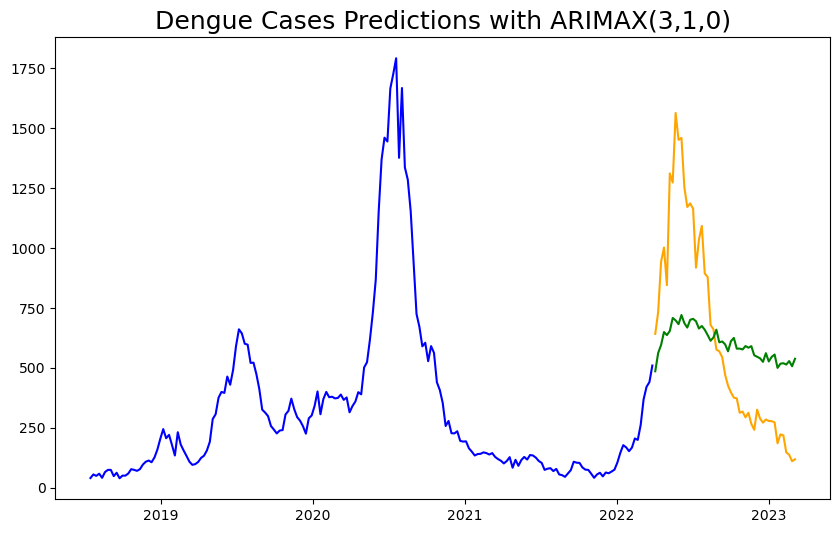

In [60]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train2['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test2['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds4, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

In [61]:
# Evaluate the predictions MSE
mean_squared_error(test2['dengue_cases'], preds4)

133429.30586689248

In [62]:
# Evaluate the predictions with mean error
mean_squared_error(test2['dengue_cases'], preds4, squared=False)

365.27976383436913

In [63]:
# Evaluation of the model
error = round(mean_squared_error(test2['dengue_cases'], preds4, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 3511.0.
MSE relative to maximum values in dengue cases: 74.0.


#### Residual Plot

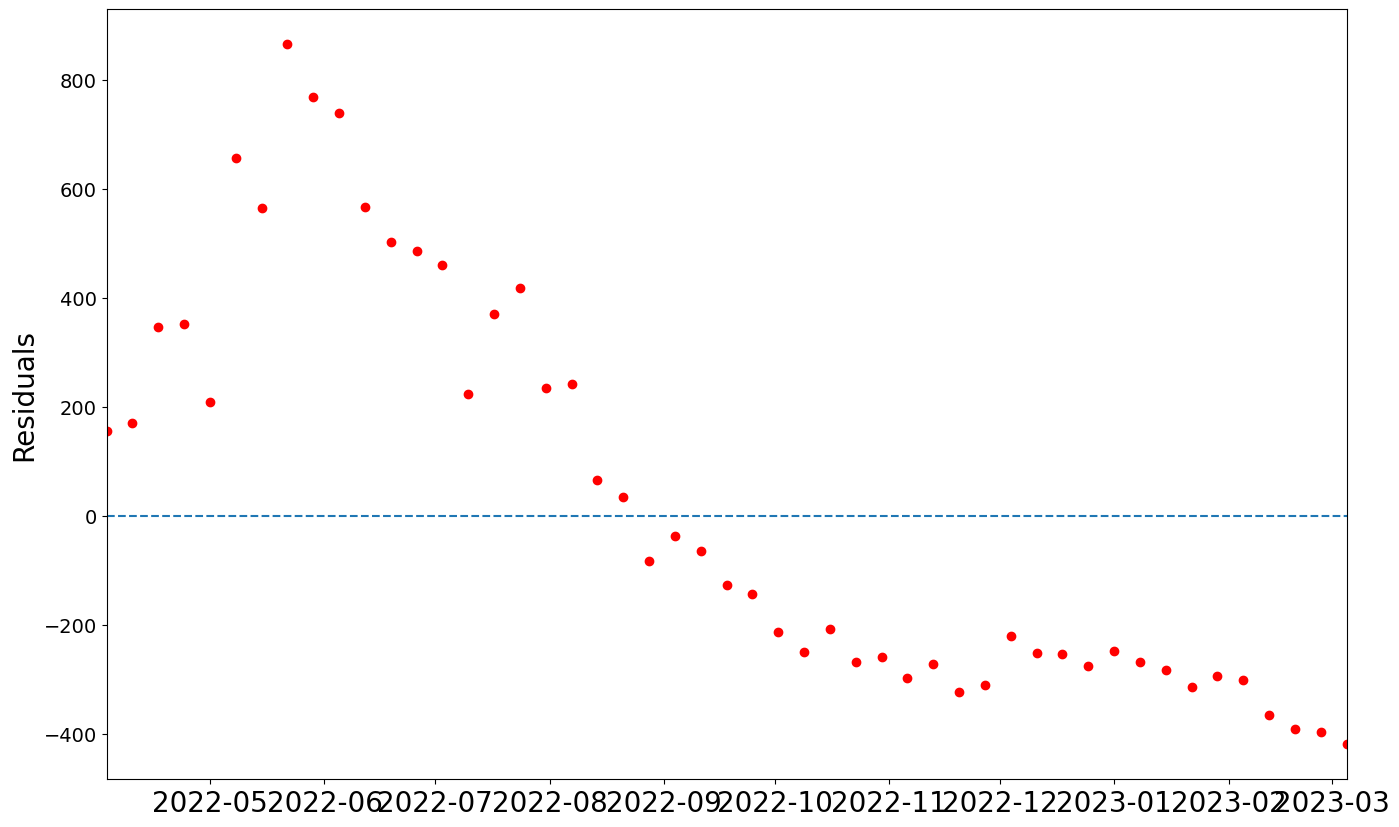

In [64]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test2['dengue_cases'].values - preds4.values

# Generate scatterplot of residuals.
plt.scatter(test2['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test2['dengue_cases'].index.min(),
           xmax = test2['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test2['dengue_cases'].index.min(), test2['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### ARIMAX Model with 14d lags

In [65]:
# Instantiate best model.
arimax5 = ARIMA(endog=train2['dengue_cases'], order=(3, 1, 0), 
               exog=train2[exogenous_features_14d])

# Fit ARIMA model.
model_5 = arimax5.fit()

# Generate predictions based on test set.
preds5 = model_5.predict(start=194, end=242, exog=test2[exogenous_features_14d])

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [66]:
print(f"test head: {test2['dengue_cases'].head(1)}")
print(f"pred head: {preds5.head(1)}")
print()
print(f"test tail: {test2['dengue_cases'].tail(1)}")
print(f"pred tail: {preds5.tail(1)}")

test head: time
2022-04-03    642
Name: dengue_cases, dtype: int64
pred head: 2022-04-03    518.860069
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    571.10458
Freq: W-SUN, Name: predicted_mean, dtype: float64


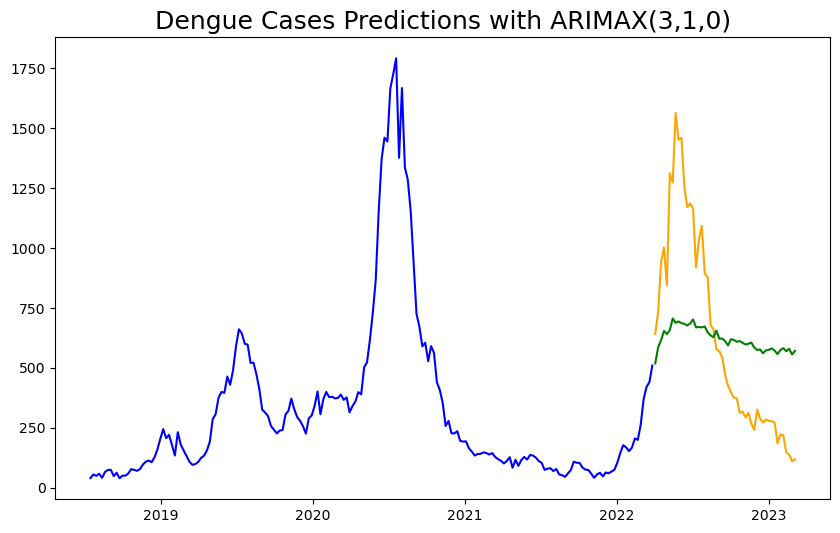

In [67]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train2['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test2['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds5, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

In [68]:
# Evaluate the predictions MSE
mean_squared_error(test2['dengue_cases'], preds5)

143954.4238049355

In [69]:
# Evaluate the predictions with mean error
mean_squared_error(test2['dengue_cases'], preds5, squared=False)

379.4132625580391

In [70]:
# Evaluation of the model
error = round(mean_squared_error(test2['dengue_cases'], preds5, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 3788.0.
MSE relative to maximum values in dengue cases: 80.0.


#### Residual Plot

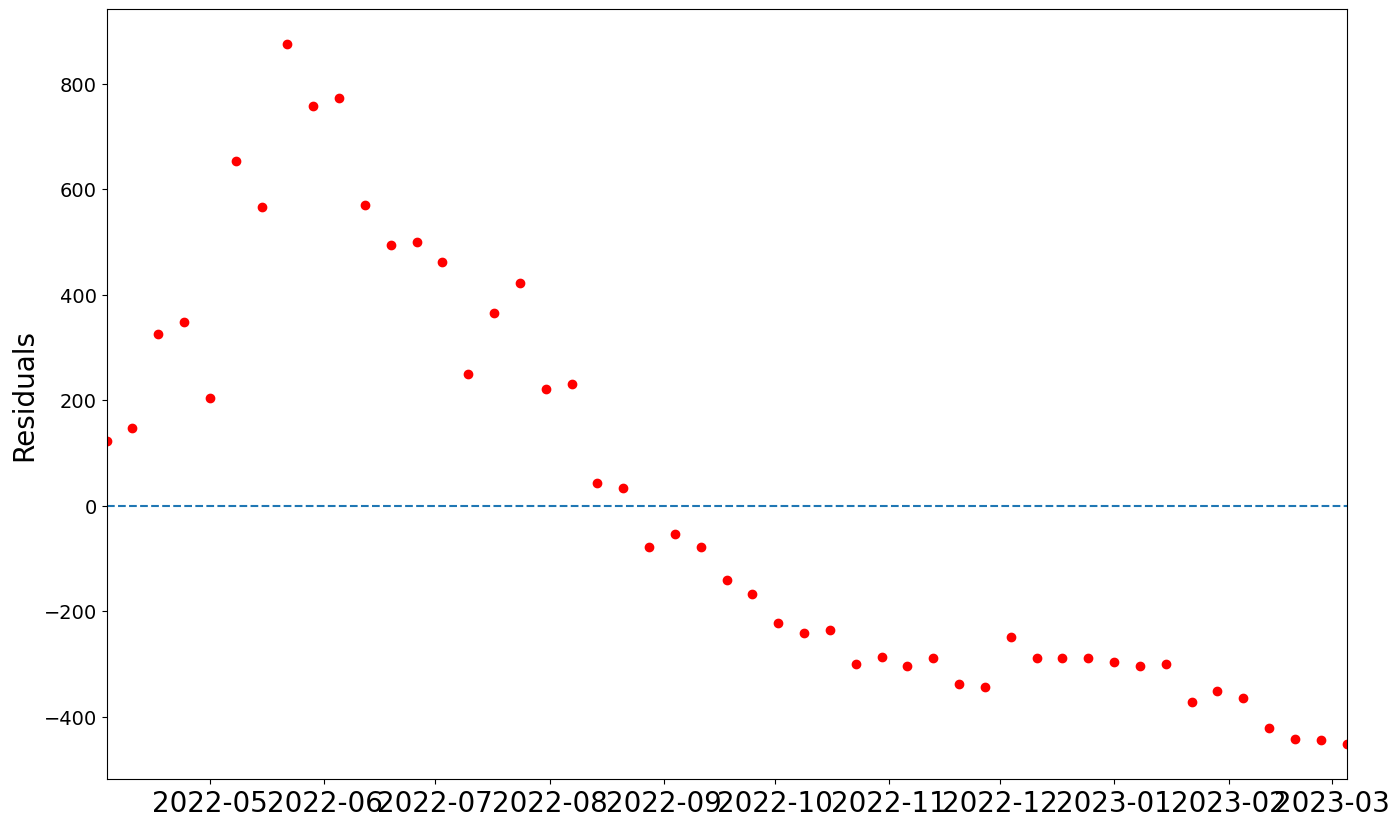

In [71]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test2['dengue_cases'].values - preds5.values

# Generate scatterplot of residuals.
plt.scatter(test2['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test2['dengue_cases'].index.min(),
           xmax = test2['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test2['dengue_cases'].index.min(), test2['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

In [72]:
data2.shape

(243, 24)

### ARIMAX With 80-20 Train Test Split (no feature engineering)

In [73]:
data.shape

(257, 12)

In [74]:
0.8 * 257

205.60000000000002

In [75]:
train3 = data.iloc[:205]
test3 = data.iloc[205:]

In [76]:
# Instantiate best model.
arimax6 = ARIMA(endog=train3['dengue_cases'], order=(3, 1, 0), 
               exog=train3.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_6 = arimax6.fit()

# Generate predictions based on test set.
preds6 = model_6.predict(start=205, end=256, exog=test3.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [77]:
print(f"test head: {test3['dengue_cases'].head(1)}")
print(f"pred head: {preds6.head(1)}")
print()
print(f"test tail: {test3['dengue_cases'].tail(1)}")
print(f"pred tail: {preds6.tail(1)}")

test head: time
2022-03-13    421
Name: dengue_cases, dtype: int64
pred head: 2022-03-13    399.514116
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    494.568913
Freq: W-SUN, Name: predicted_mean, dtype: float64


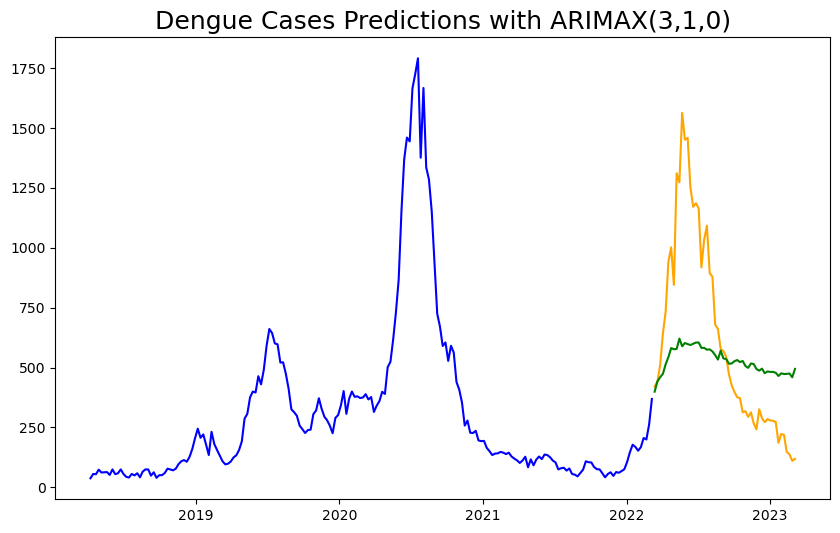

In [78]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train3['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test3['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds6, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

In [79]:
# Evaluate the predictions MSE
mean_squared_error(test3['dengue_cases'], preds6)

142600.12869998047

In [80]:
# Evaluate the predictions with mean error
mean_squared_error(test3['dengue_cases'], preds6, squared=False)

377.62432217745254

In [81]:
# Evaluation of the model
error = round(mean_squared_error(test3['dengue_cases'], preds6, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 3753.0.
MSE relative to maximum values in dengue cases: 80.0.


#### Residual Plot

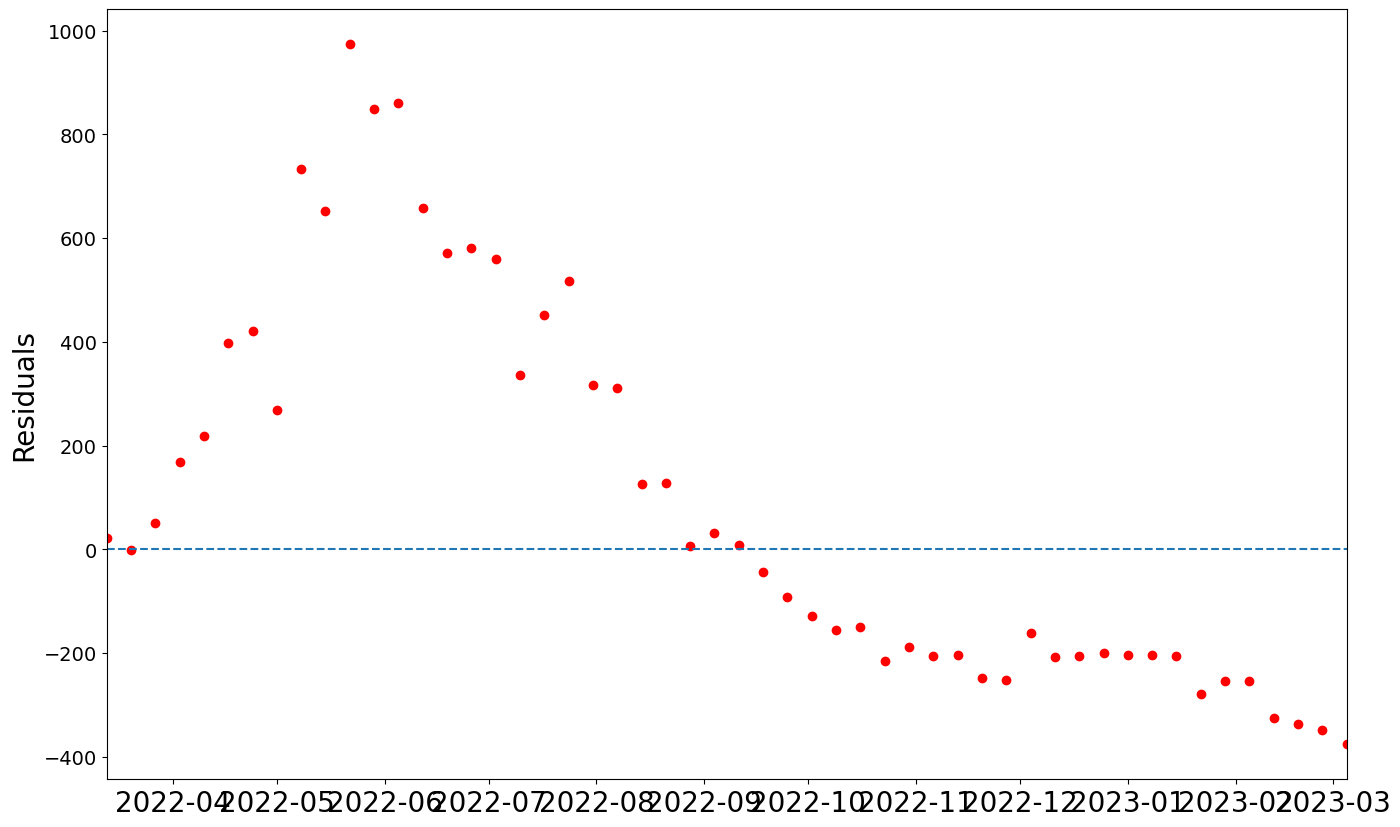

In [82]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test3['dengue_cases'].values - preds6.values

# Generate scatterplot of residuals.
plt.scatter(test3['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test3['dengue_cases'].index.min(),
           xmax = test3['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test3['dengue_cases'].index.min(), test3['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### ARIMAX Model with just Google Trends

In [84]:
# Instantiate best model.
arimax7 = ARIMA(endog=train3['dengue_cases'], order=(3, 1, 0), 
               exog=train3['google_trends'])

# Fit ARIMA model.
model_7 = arimax7.fit()

# Generate predictions based on test set.
preds7 = model_7.predict(start=205, end=256, exog=test3['google_trends'])

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

In [85]:
print(f"test head: {test3['dengue_cases'].head(1)}")
print(f"pred head: {preds7.head(1)}")
print()
print(f"test tail: {test3['dengue_cases'].tail(1)}")
print(f"pred tail: {preds7.tail(1)}")

test head: time
2022-03-13    421
Name: dengue_cases, dtype: int64
pred head: 2022-03-13    394.746685
Freq: W-SUN, Name: predicted_mean, dtype: float64

test tail: time
2023-03-05    119
Name: dengue_cases, dtype: int64
pred tail: 2023-03-05    542.20023
Freq: W-SUN, Name: predicted_mean, dtype: float64


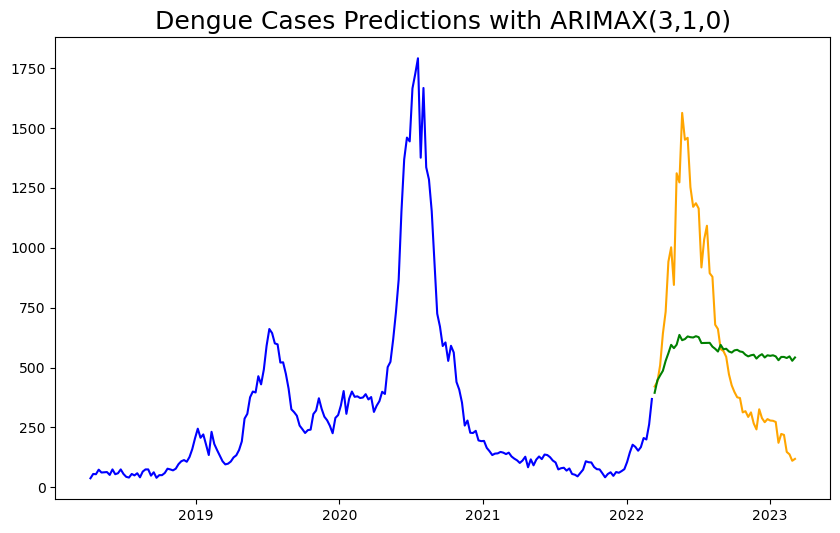

In [86]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train3['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test3['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds7, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

In [87]:
# Evaluate the predictions MSE
mean_squared_error(test3['dengue_cases'], preds7)

147727.34633753306

In [88]:
# Evaluate the predictions with mean error
mean_squared_error(test3['dengue_cases'], preds7, squared=False)

384.3531531515425

In [89]:
# Evaluation of the model
error = round(mean_squared_error(test3['dengue_cases'], preds7, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 3888.0.
MSE relative to maximum values in dengue cases: 82.0.


#### Residual Plot

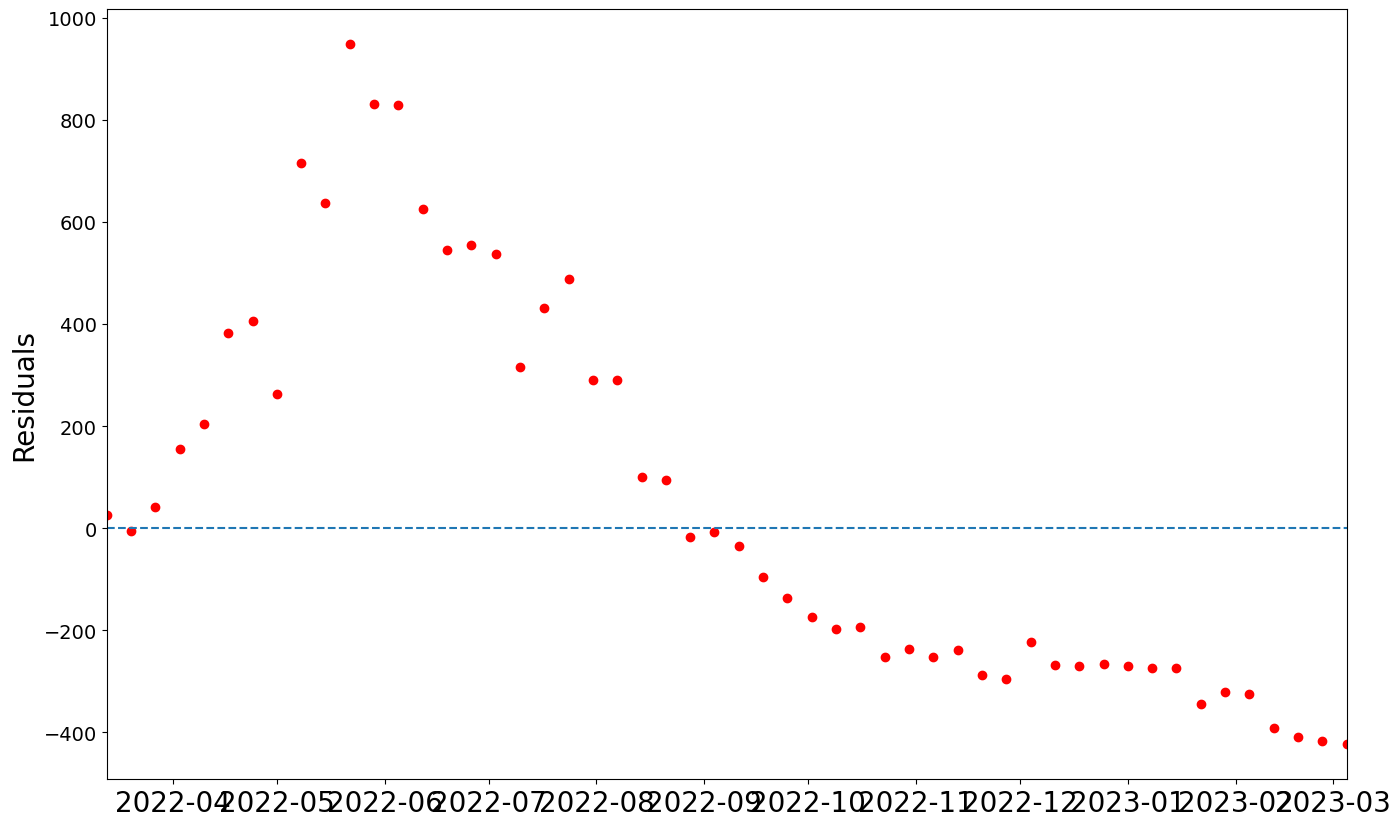

In [90]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test3['dengue_cases'].values - preds7.values

# Generate scatterplot of residuals.
plt.scatter(test3['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test3['dengue_cases'].index.min(),
           xmax = test3['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test3['dengue_cases'].index.min(), test3['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### Model with Lagged Features based on Correlation to Dengue

In [24]:
data = pd.read_csv('../datasets/data_features_with_lags.csv')

In [25]:
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [26]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [27]:
# Set the time as the index
data = data.set_index('time')

In [28]:
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [29]:
data.shape

(257, 34)

In [30]:
data.dropna(inplace=True)

In [31]:
data.shape

(206, 34)

In [32]:
data.drop(columns=['denv_1', 'denv_2', 'denv_3', 'denv_4'], inplace=True)

In [33]:
data.iloc[143] #last index for 2021

dengue_cases                      76.000000
Mean Temperature (°C)             27.785714
Mean Wind Speed (km/h)             8.485714
Daily Rainfall Total (mm)          1.514286
Maximum Temperature (°C)          32.400000
Max Wind Speed (km/h)             35.200000
Minimum Temperature (°C)          24.900000
google_trends                     15.000000
Mean Temperature (°C)_lag28       28.757143
Mean Temperature (°C)_lag51       25.971429
Mean Wind Speed (km/h)_lag6        6.057143
Mean Wind Speed (km/h)_lag22       9.714286
Mean Wind Speed (km/h)_lag47      11.357143
Maximum Temperature (°C)_10       33.200000
Maximum Temperature (°C)_lag10    33.200000
Max Wind Speed (km/h)_lag14       44.400000
Max Wind Speed (km/h)_lag41       40.700000
Minimum Temperature (°C)_lag49    23.300000
s_ratio                            0.729691
month_2                            0.000000
month_3                            0.000000
month_4                            0.000000
month_5                         

In [34]:
143/206 #We will have a 70-30 train test split

0.6941747572815534

In [39]:
train = data.iloc[:143]
test = data.iloc[143:]

In [45]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model = arimax.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

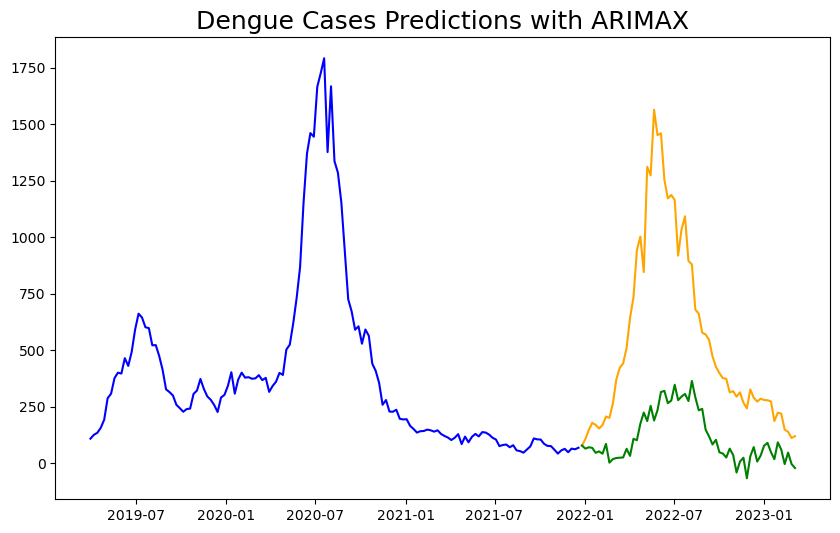

In [46]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX', fontsize=18)
plt.show();

### SARIMAX Model copied from Yusheng

In [47]:
%%time
sarimax = SARIMAX(endog=train['dengue_cases'], exog=train.drop(columns=['dengue_cases']),
                dates=train.index,
                order=(1,1,2),
                seasonal_order=(1,1,0,51),
                enforce_stationarity=False, # speed up model fitting
                enforce_invertibility=False # speed up model fitting
               )

model = sarimax.fit(maxiter=50, method='lbfgs')

preds = model.predict(start=test.index[0], end=test.index[-1],
                           exog=test.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51794D+00    |proj g|=  7.49530D-02


 This problem is unconstrained.



At iterate    5    f=  1.50078D+00    |proj g|=  3.37853D-02

At iterate   10    f=  1.48397D+00    |proj g|=  5.11498D-03

At iterate   15    f=  1.47346D+00    |proj g|=  8.00604D-03

At iterate   20    f=  1.46509D+00    |proj g|=  3.61150D-02

At iterate   25    f=  1.45818D+00    |proj g|=  3.21269D-02

At iterate   30    f=  1.44998D+00    |proj g|=  6.71219D-02

At iterate   35    f=  1.44598D+00    |proj g|=  1.44131D-02

At iterate   40    f=  1.43469D+00    |proj g|=  6.46081D-03

At iterate   45    f=  1.43291D+00    |proj g|=  3.20863D-02


/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.42983D+00    |proj g|=  7.44559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     63      1     0     0   7.446D-03   1.430D+00
  F =   1.4298333457385426     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


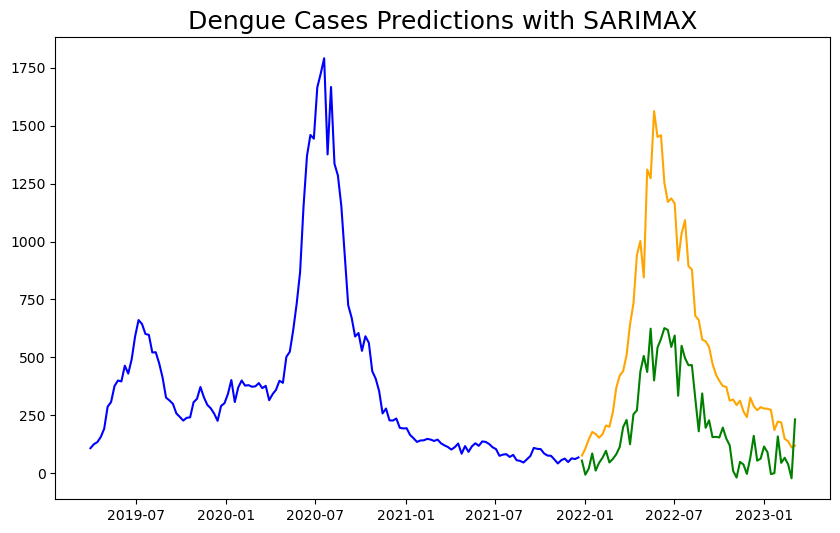

In [48]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with SARIMAX', fontsize=18)
plt.show();

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        dengue_cases   No. Observations:                  143
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 51)   Log Likelihood                -204.466
Date:                             Mon, 17 Apr 2023   AIC                            476.932
Time:                                     21:14:34   BIC                            533.493
Sample:                                 03-31-2019   HQIC                           497.226
                                      - 12-19-2021                                         
Covariance Type:                               opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Mean Temperature (°C)            -18.0709    324.706     -0.056      0.956    -654.484     618.342
Mean Wind Speed (km/h)             9.2593     67.904      0.136      0.892    -123.830     142.348
Daily Rainfall Total (mm)          3.1663     11.019      0.287      0.774     -18.431      24.763
Maximum Temperature (°C)          -9.8397    282.304     -0.035      0.972    -563.146     543.467
Max Wind Speed (km/h)             -4.2786      6.258     -0.684      0.494     -16.545       7.987
Minimum Temperature (°C)          -0.6887    148.374     -0.005      0.996    -291.497     290.120
google_trends                     10.4047     15.872      0.656      0.512     -20.703      41.512
Mean Temperature (°C)_lag28        7.5490    115.762      0.065      0.948    -219.341     234.439
Mean Temperature (°C)_lag51        0.6145    158.994      0.004      0.997    -311.008     312.237
Mean Wind Speed (km/h)_lag6       -6.0275     88.936     -0.068      0.946    -180.338     168.283
Mean Wind Speed (km/h)_lag22      -1.3906     36.837     -0.038      0.970     -73.589      70.808
Mean Wind Speed (km/h)_lag47       4.0054     24.590      0.163      0.871     -44.189      52.200
Maximum Temperature (°C)_10        5.8949     68.458      0.086      0.931    -128.280     140.070
Maximum Temperature (°C)_lag10     5.8949     68.458      0.086      0.931    -128.279     140.069
Max Wind Speed (km/h)_lag14        0.7392      6.713      0.110      0.912     -12.418      13.896
Max Wind Speed (km/h)_lag41       -1.5553     11.291     -0.138      0.890     -23.685      20.575
Minimum Temperature (°C)_lag49     0.3152     97.030      0.003      0.997    -189.861     190.491
s_ratio                         1733.9463   1.19e+04      0.146      0.884   -2.16e+04     2.5e+04
month_2                          -30.6664   1.07e+05     -0.000      1.000    -2.1e+05     2.1e+05
month_3                          -41.6439   9.09e+04     -0.000      1.000   -1.78e+05    1.78e+05
month_4                          -31.3867   9.09e+04     -0.000      1.000   -1.78e+05    1.78e+05
month_5                           -2.5490    9.1e+04   -2.8e-05      1.000   -1.78e+05    1.78e+05
month_6                           49.4470   9.09e+04      0.001      1.000   -1.78e+05    1.78e+05
month_7                          201.0056   9.09e+04      0.002      0.998   -1.78e+05    1.78e+05
month_8                          260.8908   9.09e+04      0.003      0.998   -1.78e+05    1.78e+05
month_9                          150.5460   9.09e+04      0.002      0.999   -1.78e+05    1.78e+05
month_10                          87.5376   9.08e+04      0.001      0.999   -1.78e+05    1.78e+05
month_11                          88.7797   9.08e+04      0.001      0.999   -1.78e+05    1.78e+05
month_12                          34.1233   9.08e+04   

### Auto ARIMA

In [ ]:
# Install pmdarina at your own risk. It casues a lot of issues with the dependencies. 
from pmdarima.arima import auto_arima

In [ ]:
model_auto = auto_arima(train['dengue_cases'], exogenous=train.drop(columns=['dengue_cases']), 
                       trace=True, error_action='ignore', suppress_warnings=True)

In [ ]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
#preds = model.predict(start=196, end=257)
preds_auto = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_auto, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();